In [ ]:
import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio

# visualization settings
plt.style.use('seaborn')
plt.rcParams['figure.facecolor'] = 'white'
pio.renderers.default = 'colab'

# prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric
from prophet import Prophet #, hdays

# evaluation metric
from sklearn.metrics import mean_squared_log_error

# others
import itertools
from tqdm import tqdm

<ipython-input-1-99f494e4527b>:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [ ]:
sales = pd.read_csv('/content/drive/MyDrive/sales_train.csv')
sales.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0

In [ ]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [ ]:
sales['date'] = pd.to_datetime(sales['date'], dayfirst=True)
sales.sort_values('date', inplace=True)
sales['total_revenue'] = sales['item_price'] * sales['item_cnt_day']
sales.dtypes

date              datetime64[ns]
date_block_num             int64
shop_id                    int64
item_id                    int64
item_price               float64
item_cnt_day             float64
total_revenue            float64
dtype: object

In [ ]:
date = pd.Series(['30-01-2021', '31-01-2021', '01-02-2021', '02-02-2021'])
pd.to_datetime(date)

<ipython-input-7-18dabd8fc79c>:2: UserWarning:

Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.



0   2021-01-30
1   2021-01-31
2   2021-02-01
3   2021-02-02
dtype: datetime64[ns]

In [ ]:
sales['date'].apply(['min', 'max'])

min   2013-01-01
max   2015-10-31
Name: date, dtype: datetime64[ns]

In [ ]:
top_3_shop = sales['shop_id'].value_counts().head(3)
top_3_shop

shop_id
31    235636
25    186104
54    143480
Name: count, dtype: int64

In [ ]:
sales_top_3_shop = sales[sales['shop_id'].isin(top_3_shop.index)]
sales_top_3_shop.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
84820 2013-01-01               0       54    12370       149.0           1.0   
85870 2013-01-01               0       54    13431     11489.7           1.0   
87843 2013-01-01               0       54     8709       349.0           1.0   
76711 2013-01-01               0       54    20144       249.0           1.0   
87341 2013-01-01               0       54    10458       298.0           1.0   

       total_revenue  
84820          149.0  
85870        11489.7  
87843          349.0  
76711          249.0  
87341          298.0

In [ ]:
daily_sales = sales_top_3_shop.groupby(['date', 'shop_id'])[['item_cnt_day', 'total_revenue']] \
    .sum().reset_index() \
    .rename(columns={'item_cnt_day': 'total_qty'})
daily_sales.head()

date  shop_id  total_qty  total_revenue
0 2013-01-01       54      415.0      316557.00
1 2013-01-02       25      568.0      345174.13
2 2013-01-02       31      568.0      396376.10
3 2013-01-02       54      709.0      519336.00
4 2013-01-03       25      375.0      249421.00

Multiple Time Series

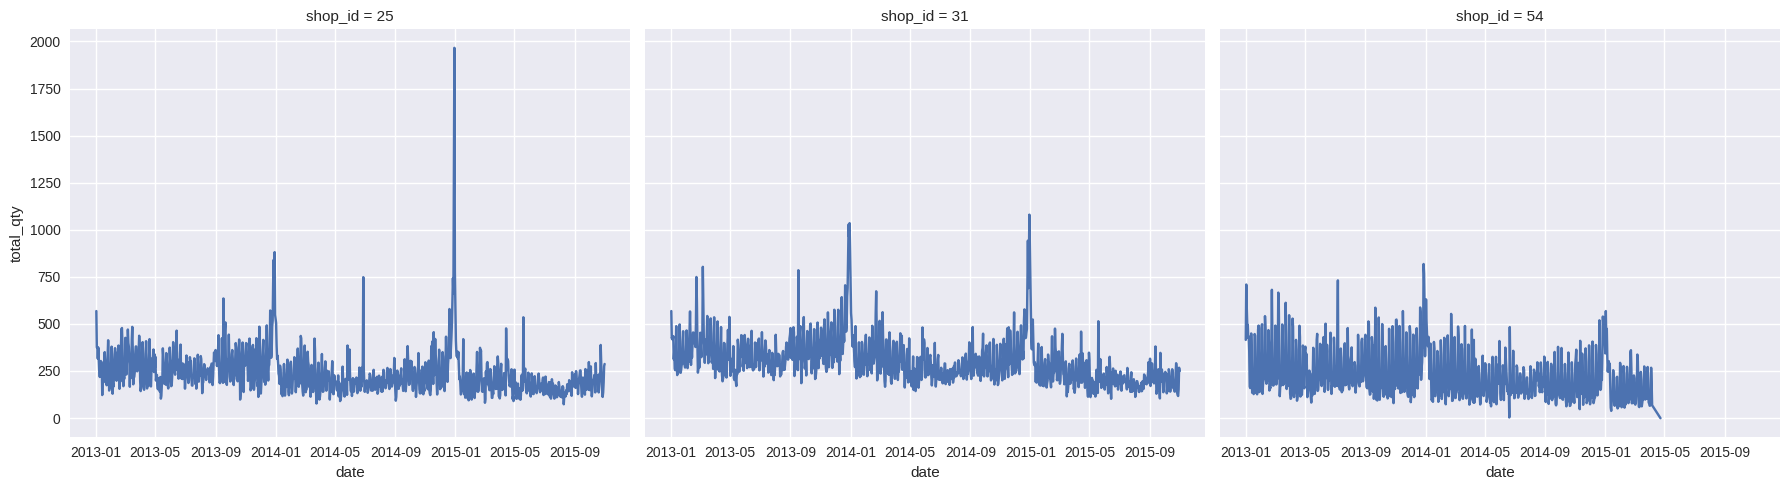

In [ ]:
sns.relplot(data=daily_sales,
            kind='line',
            x='date',
            y='total_qty',
            col='shop_id',
            aspect=6/5)
plt.show()

Multivariate Time Series


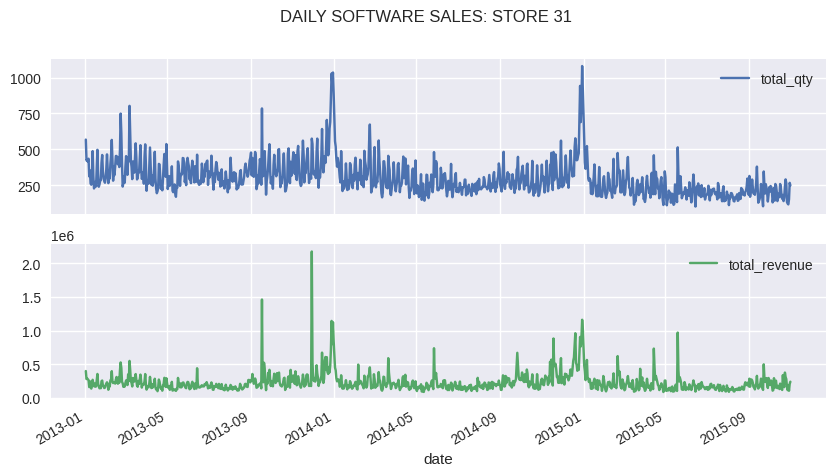

In [ ]:
daily_sales_31 = daily_sales[daily_sales['shop_id'] == 31].reset_index(drop=True)
daily_sales_31.set_index('date')[['total_qty', 'total_revenue']].plot(subplots=True,
                                                                      figsize=(10, 5))
plt.suptitle('DAILY SOFTWARE SALES: STORE 31')
plt.show()

Modeling using fbprophet

Minimal Workflow

In [ ]:
daily_total_qty = daily_sales_31[['date', 'total_qty']].rename(
    columns={'date': 'ds',
             'total_qty': 'y'})

daily_total_qty.head()

ds      y
0 2013-01-02  568.0
1 2013-01-03  423.0
2 2013-01-04  431.0
3 2013-01-05  415.0
4 2013-01-06  435.0

In [ ]:
model_31 = Prophet()
model_31.fit(daily_total_qty)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmps54gh3zr/p5lhxua5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmps54gh3zr/2pjn1jbi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34755', 'data', 'file=/tmp/tmps54gh3zr/p5lhxua5.json', 'init=/tmp/tmps54gh3zr/2pjn1jbi.json', 'output', 'file=/tmp/tmps54gh3zr/prophet_modeloka_nda4/prophet_model-20240824114208.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:42:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:42:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future_31 = model_31.make_future_dataframe(periods=365, freq='D')
future_31.tail()

ds
1391 2016-10-26
1392 2016-10-27
1393 2016-10-28
1394 2016-10-29
1395 2016-10-30

In [ ]:
forecast_31 = model_31.predict(future_31)
forecast_31[['ds', 'trend', 'weekly', 'yearly', 'yhat']]

ds       trend     weekly      yearly        yhat
0    2013-01-02  376.187760 -32.835488  234.582774  577.935045
1    2013-01-03  376.114306 -26.062247  215.059990  565.112049
2    2013-01-04  376.040853  55.639372  193.954001  625.634226
3    2013-01-05  375.967399  82.005820  171.608500  629.581719
4    2013-01-06  375.893945  -2.451293  148.385269  521.827921
...         ...         ...        ...         ...         ...
1391 2016-10-26  153.536235 -32.835488  -32.504871   88.195875
1392 2016-10-27  153.355167 -26.062247  -30.546461   96.746459
1393 2016-10-28  153.174099  55.639372  -27.664184  181.149288
1394 2016-10-29  152.993031  82.005820  -23.868573  211.130278
1395 2016-10-30  152.811963  -2.451293  -19.195824  131.164846

[1396 rows x 5 columns]

In [ ]:
forecast_result = forecast_31['yhat']
forecast_add_components = forecast_31['trend'] + forecast_31['weekly'] + forecast_31['yearly']

(forecast_result.round(10) == forecast_add_components.round(10)).all()

True

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



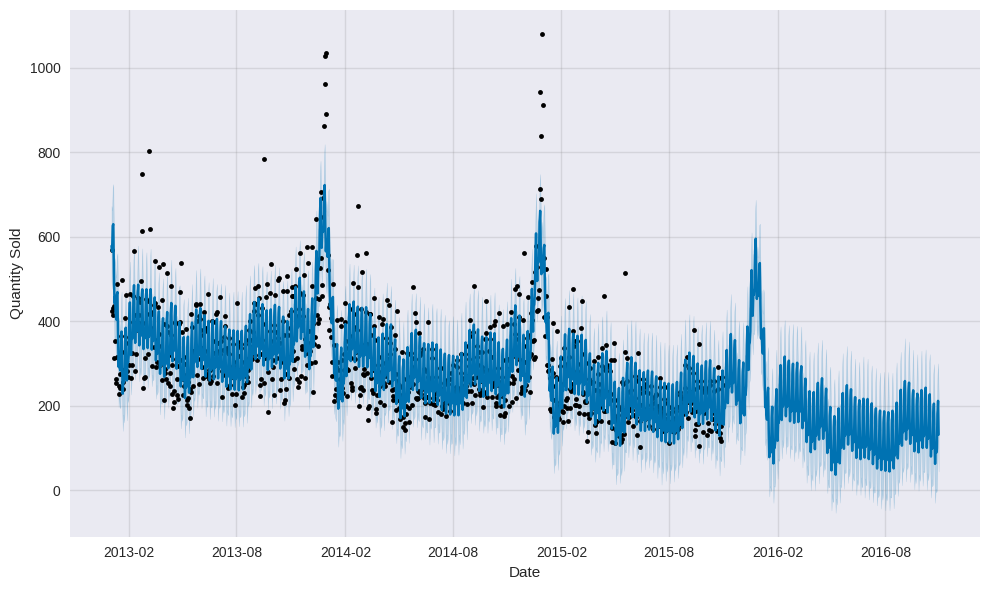

In [ ]:
fig = model_31.plot(forecast_31, xlabel='Date', ylabel='Quantity Sold')

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:351: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:354: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



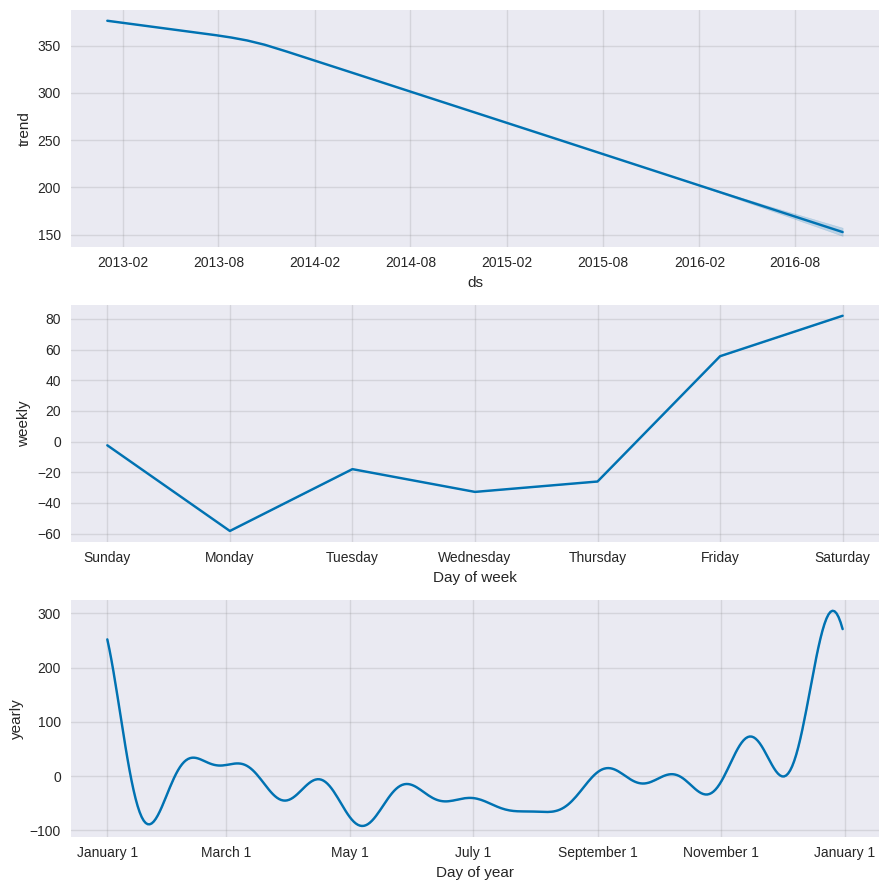

In [ ]:
fig = model_31.plot_components(forecast_31)

In [ ]:
plot_plotly(model_31, forecast_31)

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [ ]:
plot_components_plotly(model_31, forecast_31)

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



Trend Component

<ipython-input-24-d59d9da931f4>:16: UserWarning:

FixedFormatter should only be used together with FixedLocator



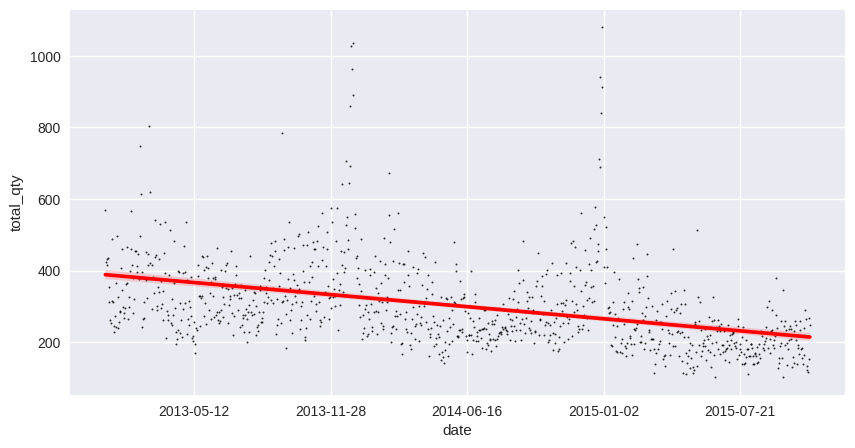

In [ ]:
# for illustration purposes only
from datetime import date

# prepare data
daily_sales_31_copy = daily_sales_31.copy()
daily_sales_31_copy['date_ordinal'] = daily_sales_31_copy['date'].apply(lambda date: date.toordinal())

# visualize regression line
plt.figure(figsize=(10, 5))
ax = sns.regplot(x='date_ordinal',
                 y='total_qty',
                 data=daily_sales_31_copy,
                 scatter_kws={'color': 'black', 's': 2},
                 line_kws={'color': 'red'})
new_labels = [date.fromordinal(int(item)) for item in ax.get_xticks()]
ax.set_xticklabels(new_labels)
plt.xlabel('date')
plt.show()

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



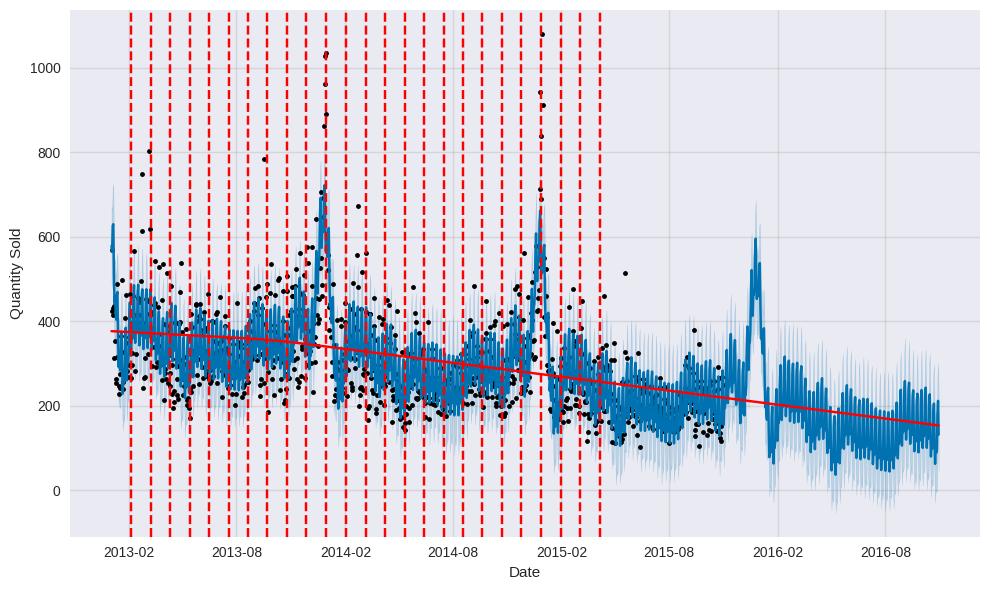

In [ ]:
# for illustration purposes only
from prophet.plot import add_changepoints_to_plot
fig = model_31.plot(forecast_31, xlabel='Date', ylabel='Quantity Sold')
a = add_changepoints_to_plot(fig.gca(), model_31, forecast_31, threshold=0)

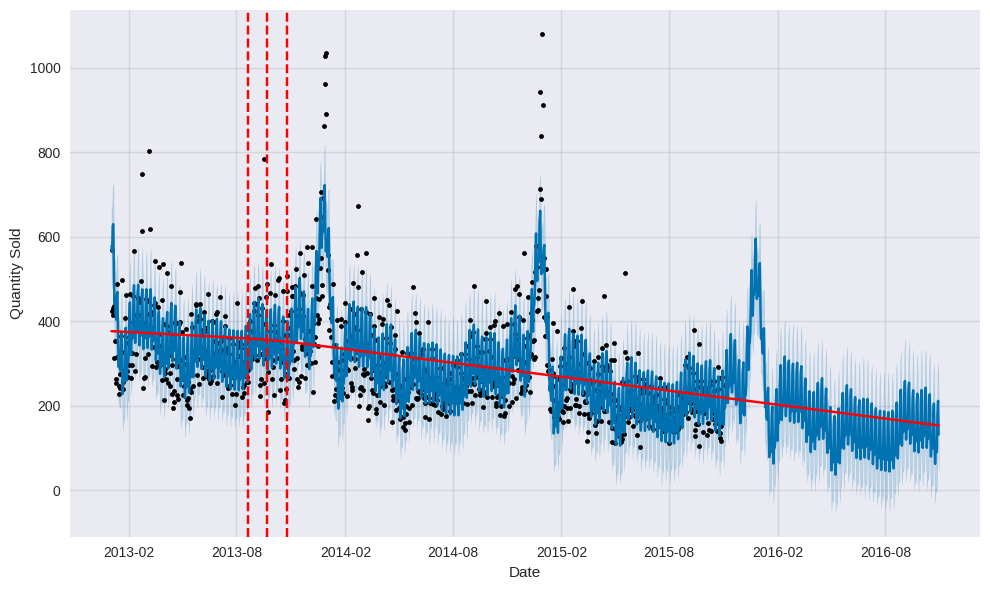

In [ ]:
fig = model_31.plot(forecast_31, xlabel='Date', ylabel='Quantity Sold')
a = add_changepoints_to_plot(fig.gca(), model_31, forecast_31)

Adjusting Trend Flexibility

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmps54gh3zr/spv6jppm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmps54gh3zr/e54t_bbs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65200', 'data', 'file=/tmp/tmps54gh3zr/spv6jppm.json', 'init=/tmp/tmps54gh3zr/e54t_bbs.json', 'output', 'file=/tmp/tmps54gh3zr/prophet_model_n2499vc/prophet_model-20240824114600.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:46:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:46:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in

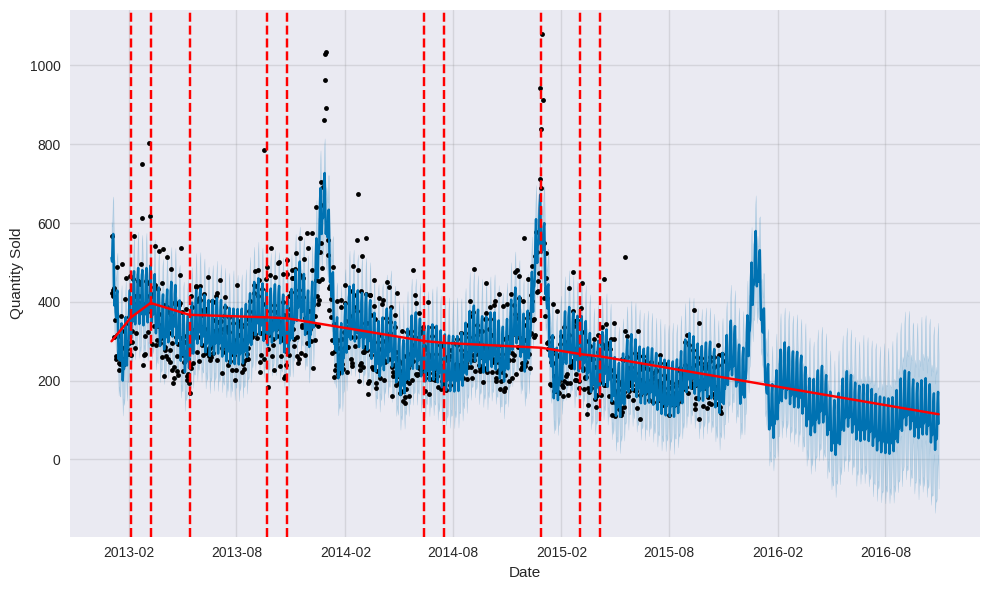

In [ ]:
model_tuning_trend = Prophet(
    n_changepoints=25,  # default = 25
    changepoint_range=0.8,  # default = 0.8
    changepoint_prior_scale=0.5  # default = 0.05
)
model_tuning_trend.fit(daily_total_qty)

# forecasting
future = model_tuning_trend.make_future_dataframe(periods=365, freq='D')
forecast = model_tuning_trend.predict(future)

# visualize
fig = model_tuning_trend.plot(forecast, xlabel='Date', ylabel='Quantity Sold')
a = add_changepoints_to_plot(fig.gca(), model_tuning_trend, forecast)

Seasonality Component

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:351: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:354: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



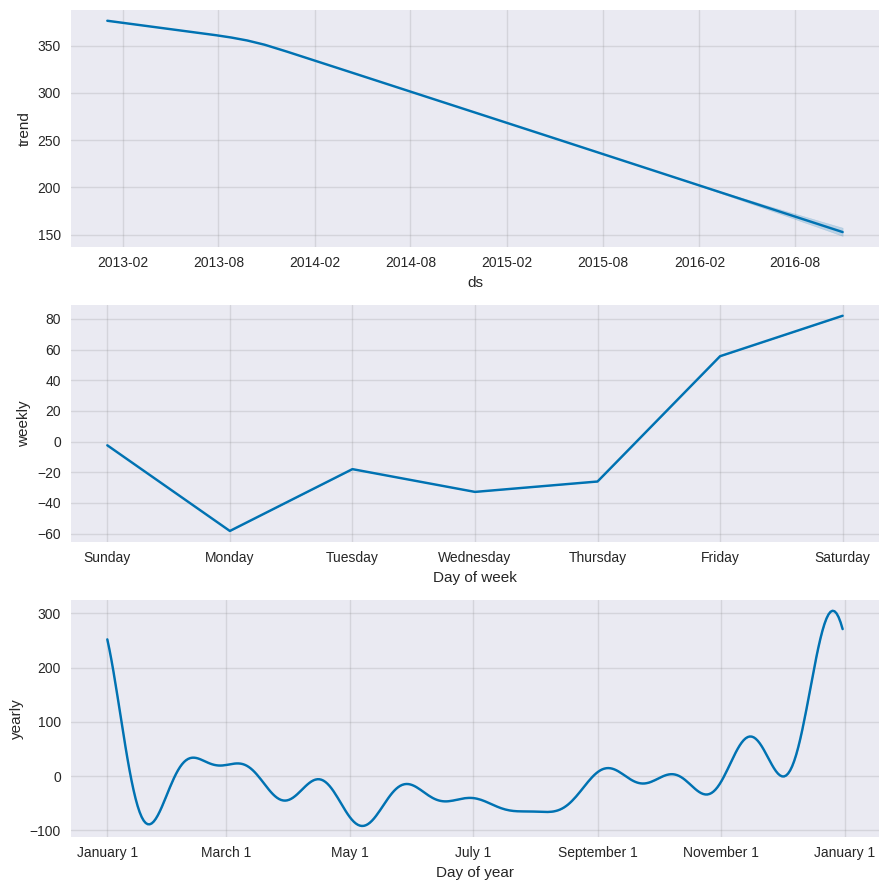

In [ ]:
fig = model_31.plot_components(forecast_31)

Fourier Order

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmps54gh3zr/un5xlkmw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmps54gh3zr/a2w7xzy3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56517', 'data', 'file=/tmp/tmps54gh3zr/un5xlkmw.json', 'init=/tmp/tmps54gh3zr/a2w7xzy3.json', 'output', 'file=/tmp/tmps54gh3zr/prophet_modelr3kg4ayg/prophet_model-20240824114700.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:47:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:47:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, i

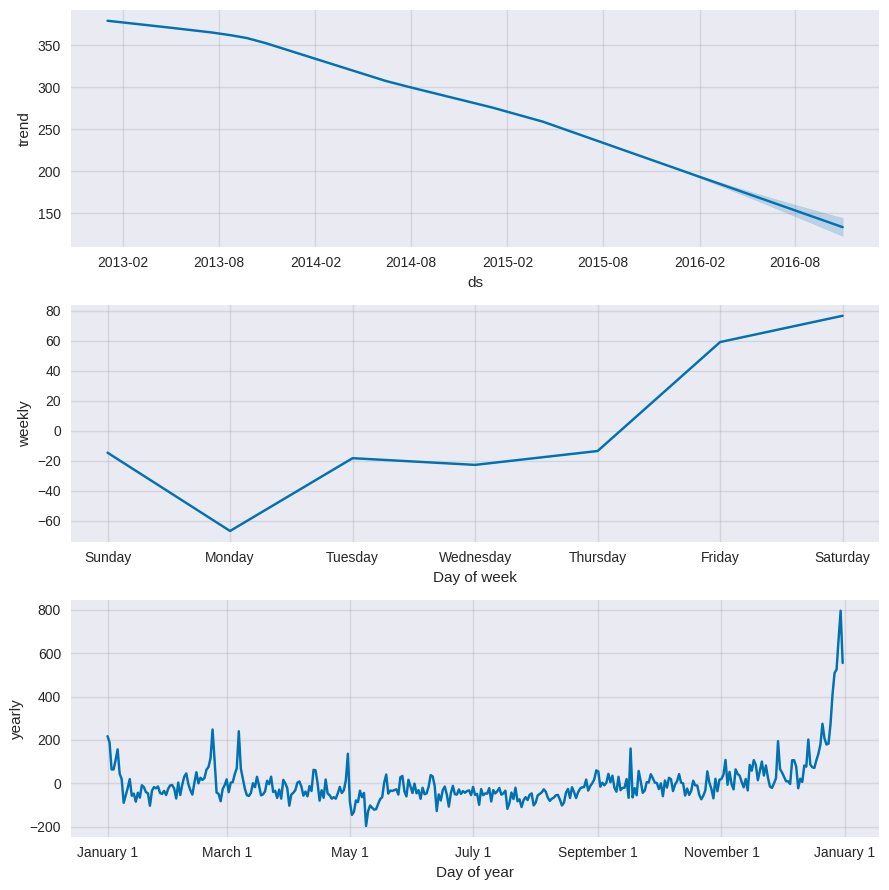

In [ ]:
model_tuning_seasonality = Prophet(
    weekly_seasonality=3,  # default = 3
    yearly_seasonality=200  # default = 10
)
model_tuning_seasonality.fit(daily_total_qty)

# forecasting
future = model_tuning_seasonality.make_future_dataframe(periods=365, freq='D')
forecast = model_tuning_seasonality.predict(future)

# visualize
fig = model_tuning_seasonality.plot_components(forecast)

Custom Seasonalities

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmps54gh3zr/qzlwruij.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmps54gh3zr/4ep29jsf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12388', 'data', 'file=/tmp/tmps54gh3zr/qzlwruij.json', 'init=/tmp/tmps54gh3zr/4ep29jsf.json', 'output', 'file=/tmp/tmps54gh3zr/prophet_modelt7w4p24i/prophet_model-20240824114722.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:47:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:47:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, i

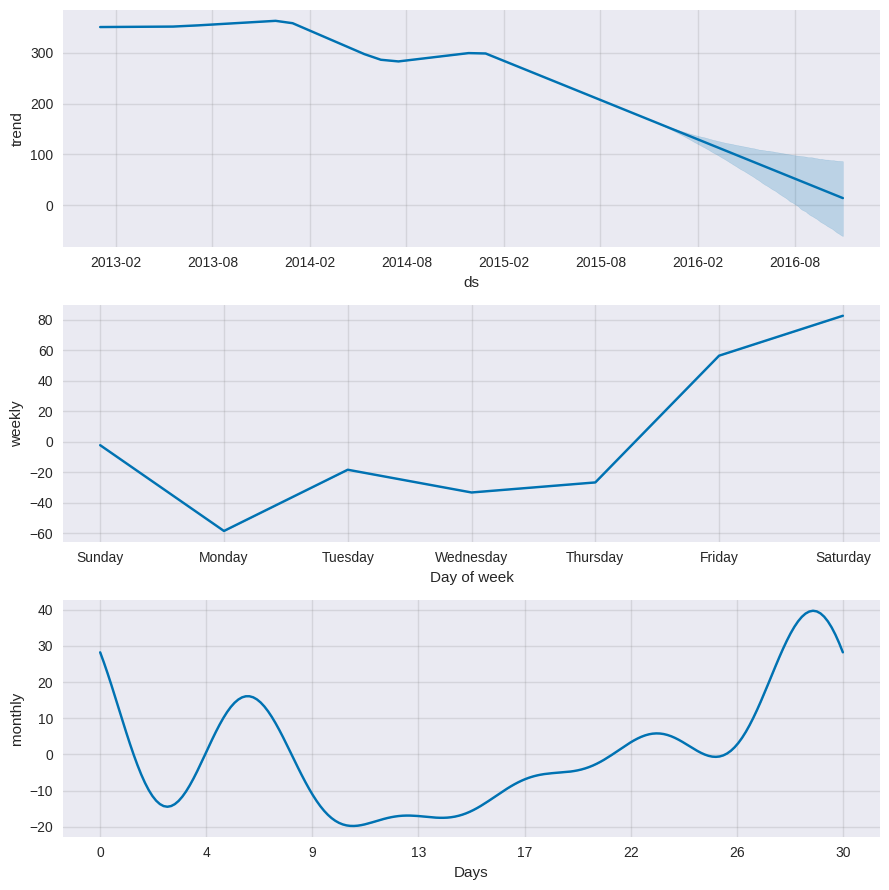

In [ ]:
model_custom_seasonality = Prophet(
    yearly_seasonality=False  # remove seasonality
)
# add seasonality
model_custom_seasonality.add_seasonality(
    name='monthly', period=30.5, fourier_order=5)
model_custom_seasonality.fit(daily_total_qty)

# forecasting
future = model_custom_seasonality.make_future_dataframe(periods=365, freq='D')
forecast = model_custom_seasonality.predict(future)

# visualize
fig = model_custom_seasonality.plot_components(forecast)

Holiday Effects

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



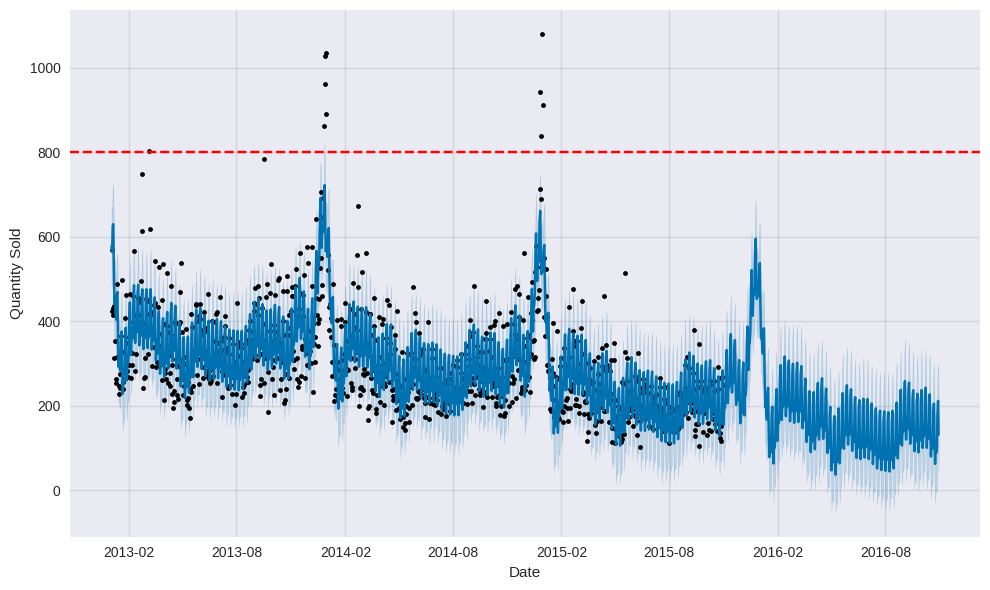

In [ ]:
fig = model_31.plot(forecast_31, xlabel='Date', ylabel='Quantity Sold')
plt.axhline(y=800, color='red', ls='--')
plt.show()

In [ ]:
daily_total_qty[daily_total_qty['y'] > 800]

ds       y
64  2013-03-07   803.0
359 2013-12-27   861.0
360 2013-12-28  1028.0
361 2013-12-29   962.0
362 2013-12-30  1035.0
363 2013-12-31   891.0
723 2014-12-27   942.0
725 2014-12-29   839.0
726 2014-12-30  1080.0
727 2014-12-31   912.0

In [ ]:
holiday = pd.DataFrame({
    'holiday': 'new_year_eve',
    'ds': pd.to_datetime(['2013-12-31', '2014-12-31',  # past date, historical data
                          '2015-12-31']),  # future date, to be forecasted
    'lower_window': -4,  # include 27th - 31st December
    'upper_window': 0})
holiday

holiday         ds  lower_window  upper_window
0  new_year_eve 2013-12-31            -4             0
1  new_year_eve 2014-12-31            -4             0
2  new_year_eve 2015-12-31            -4             0

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmps54gh3zr/1a_d_v46.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmps54gh3zr/yl00ib27.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68267', 'data', 'file=/tmp/tmps54gh3zr/1a_d_v46.json', 'init=/tmp/tmps54gh3zr/yl00ib27.json', 'output', 'file=/tmp/tmps54gh3zr/prophet_model3swz_kn0/prophet_model-20240824114859.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:48:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:48:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in

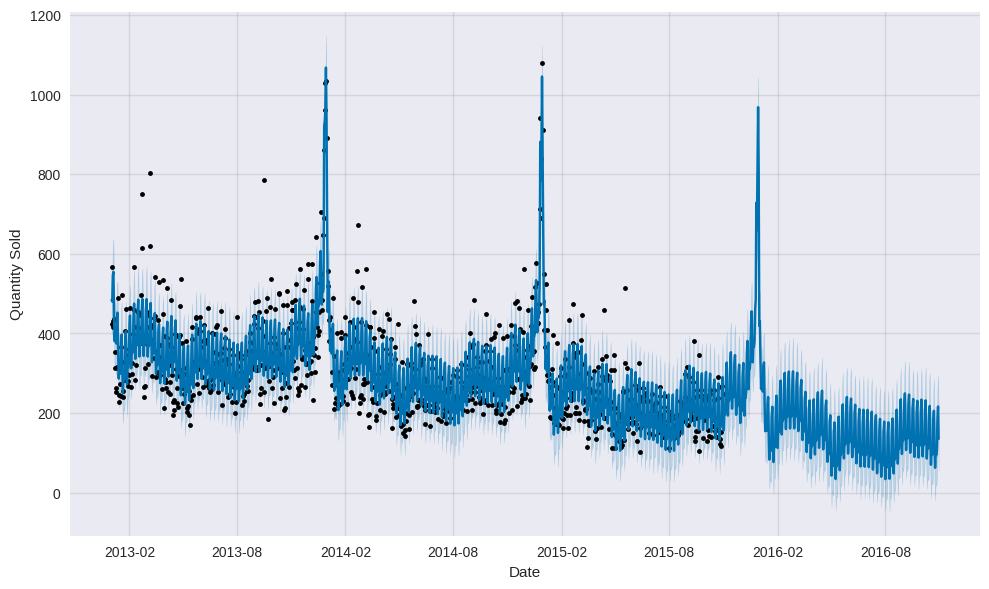

In [ ]:
model_holiday = Prophet(holidays=holiday)
model_holiday.fit(daily_total_qty)

# forecasting
future = model_holiday.make_future_dataframe(periods=365, freq='D')
forecast = model_holiday.predict(future)

# visualize
fig = model_holiday.plot(forecast, xlabel='Date', ylabel='Quantity Sold')


/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:351: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:354: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



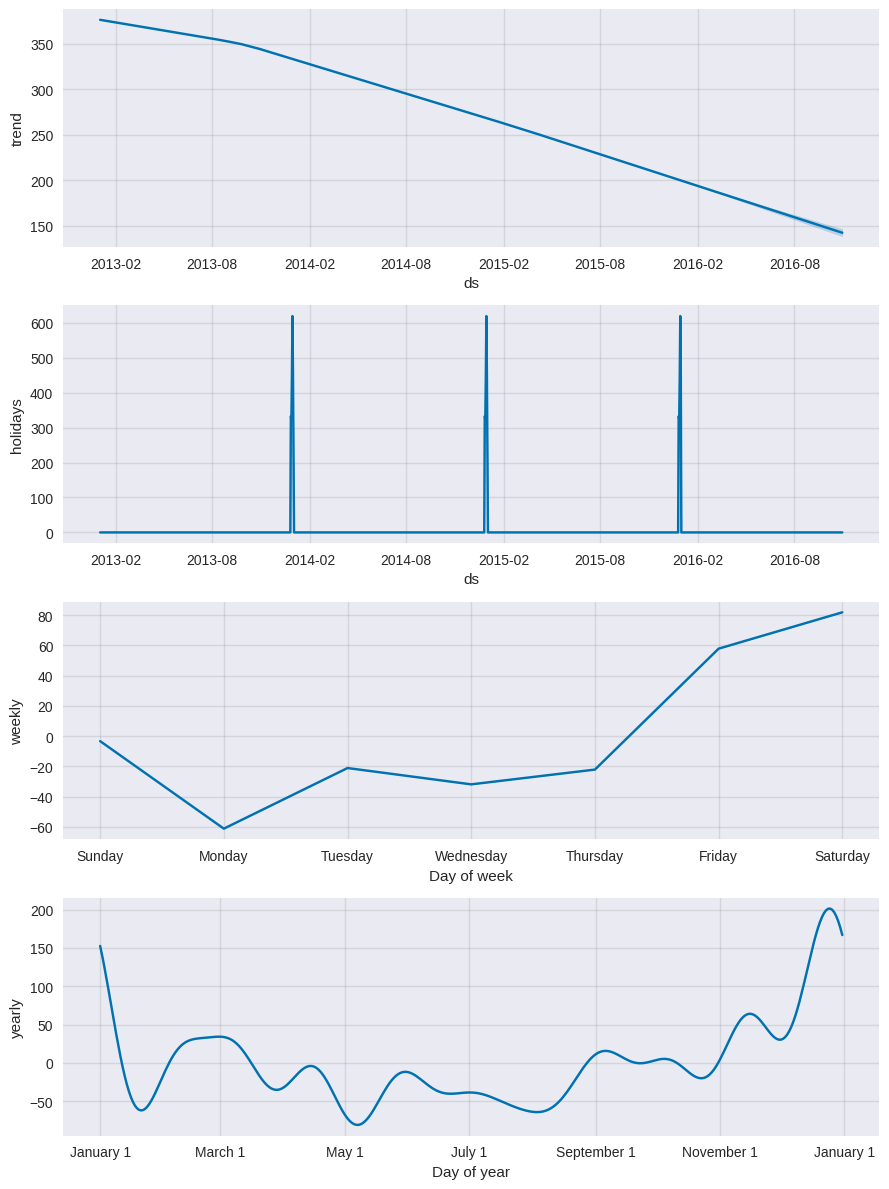

In [ ]:
fig = model_holiday.plot_components(forecast)

In [ ]:
model_holiday_indo = Prophet()
model_holiday_indo.add_country_holidays(country_name='ID')
model_holiday_indo.fit(daily_total_qty)

model_holiday_indo.train_holiday_names

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmps54gh3zr/0z4hmqif.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmps54gh3zr/nvms0q49.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32574', 'data', 'file=/tmp/tmps54gh3zr/0z4hmqif.json', 'init=/tmp/tmps54gh3zr/nvms0q49.json', 'output', 'file=/tmp/tmps54gh3zr/prophet_model4a2m4up2/prophet_model-20240824114922.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:49:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:49:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


0              New Year's Day
1              Lunar New Year
2              Day of Silence
3                 Good Friday
4           Buddha's Birthday
5               Ascension Day
6            Independence Day
7               Christmas Day
8                 Eid al-Fitr
9      Eid al-Fitr Second Day
10                Eid al-Adha
11           Islamic New Year
12         Prophet's Birthday
13             Isra and Miraj
14    International Labor Day
dtype: object

In [ ]:
holidays_indo = hdays.Indonesia()
holidays_indo._populate(2021)
pd.DataFrame([holidays_indo], index=['holiday']).T.rename_axis('ds').reset_index()

NameError: name 'hdays' is not defined

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmps54gh3zr/5slmmkx0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmps54gh3zr/yv6u5zc2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18559', 'data', 'file=/tmp/tmps54gh3zr/5slmmkx0.json', 'init=/tmp/tmps54gh3zr/yv6u5zc2.json', 'output', 'file=/tmp/tmps54gh3zr/prophet_modelhhdkkx0j/prophet_model-20240824115604.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:56:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:56:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in

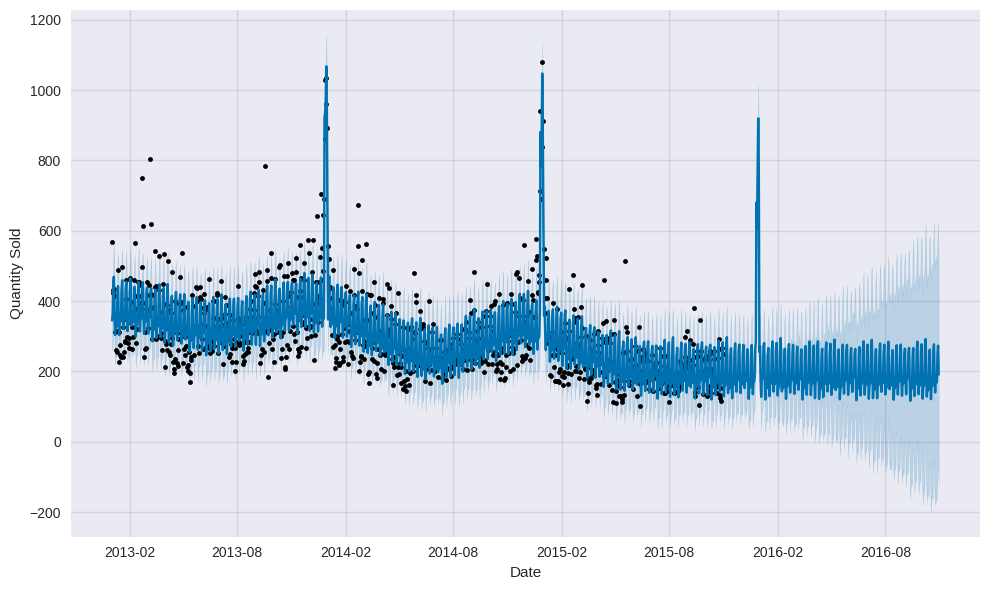

In [ ]:
model_total_qty = Prophet(
    n_changepoints=20,  # trend flexibility
    changepoint_range=0.9,  # trend flexibility
    changepoint_prior_scale=0.25,  # trend flexibility
    weekly_seasonality=5,  # seasonality fourier order
    yearly_seasonality=False,  # remove seasonality
    holidays=holiday  # new year eve effects
)
# add monthly seasonality
model_total_qty.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model_total_qty.fit(daily_total_qty)

# forecasting
future = model_total_qty.make_future_dataframe(periods=365, freq='D')
forecast_total_qty = model_total_qty.predict(future)

# visualize
fig = model_total_qty.plot(
    forecast_total_qty, xlabel='Date', ylabel='Quantity Sold')

In [ ]:
forecasted_total_qty = forecast_total_qty[['ds', 'yhat']].tail(365) \
    .rename(columns={'yhat': 'total_qty'})
forecasted_total_qty

ds   total_qty
1031 2015-11-01  193.597307
1032 2015-11-02  129.111104
1033 2015-11-03  165.197627
1034 2015-11-04  158.600593
1035 2015-11-05  179.149283
...         ...         ...
1391 2016-10-26  167.774600
1392 2016-10-27  173.101888
1393 2016-10-28  249.522513
1394 2016-10-29  273.358998
1395 2016-10-30  191.288933

[365 rows x 2 columns]

In [ ]:
actual_total_qty = daily_total_qty.rename(columns={'y': 'total_qty'})
actual_total_qty

ds  total_qty
0    2013-01-02      568.0
1    2013-01-03      423.0
2    2013-01-04      431.0
3    2013-01-05      415.0
4    2013-01-06      435.0
...         ...        ...
1026 2015-10-27      123.0
1027 2015-10-28      117.0
1028 2015-10-29      152.0
1029 2015-10-30      267.0
1030 2015-10-31      249.0

[1031 rows x 2 columns]

In [ ]:
future_with_regressor = pd.concat([actual_total_qty, forecasted_total_qty])
future_with_regressor

ds   total_qty
0    2013-01-02  568.000000
1    2013-01-03  423.000000
2    2013-01-04  431.000000
3    2013-01-05  415.000000
4    2013-01-06  435.000000
...         ...         ...
1391 2016-10-26  167.774600
1392 2016-10-27  173.101888
1393 2016-10-28  249.522513
1394 2016-10-29  273.358998
1395 2016-10-30  191.288933

[1396 rows x 2 columns]

Forecast the Target Variable (total_revenue)

In [ ]:
daily_total_revenue = daily_sales_31[['date', 'total_revenue', 'total_qty']].rename(
    columns={'date': 'ds',
             'total_revenue': 'y'})

daily_total_revenue.head()

ds          y  total_qty
0 2013-01-02  396376.10      568.0
1 2013-01-03  276933.11      423.0
2 2013-01-04  286408.00      431.0
3 2013-01-05  273245.00      415.0
4 2013-01-06  260775.00      435.0

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmps54gh3zr/p45hy1s1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmps54gh3zr/hq70ding.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52699', 'data', 'file=/tmp/tmps54gh3zr/p45hy1s1.json', 'init=/tmp/tmps54gh3zr/hq70ding.json', 'output', 'file=/tmp/tmps54gh3zr/prophet_model4ak85_j6/prophet_model-20240824115724.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:57:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:57:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in

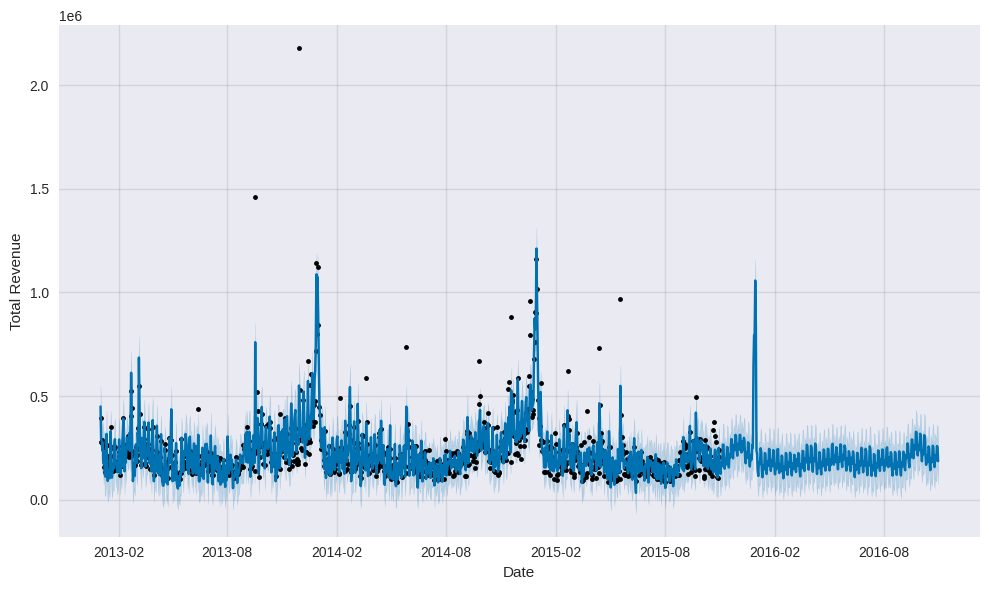

In [ ]:
model_total_revenue = Prophet(
    holidays=holiday  # new year eve effects
)
# add regressor
model_total_revenue.add_regressor('total_qty')
model_total_revenue.fit(daily_total_revenue)

# forecasting
# use dataframe with regressor, instead of just `ds` column
forecast_total_revenue = model_total_revenue.predict(future_with_regressor)

# visualize
fig = model_total_revenue.plot(
    forecast_total_revenue, xlabel='Date', ylabel='Total Revenue')

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:351: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:354: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning:

The behavio

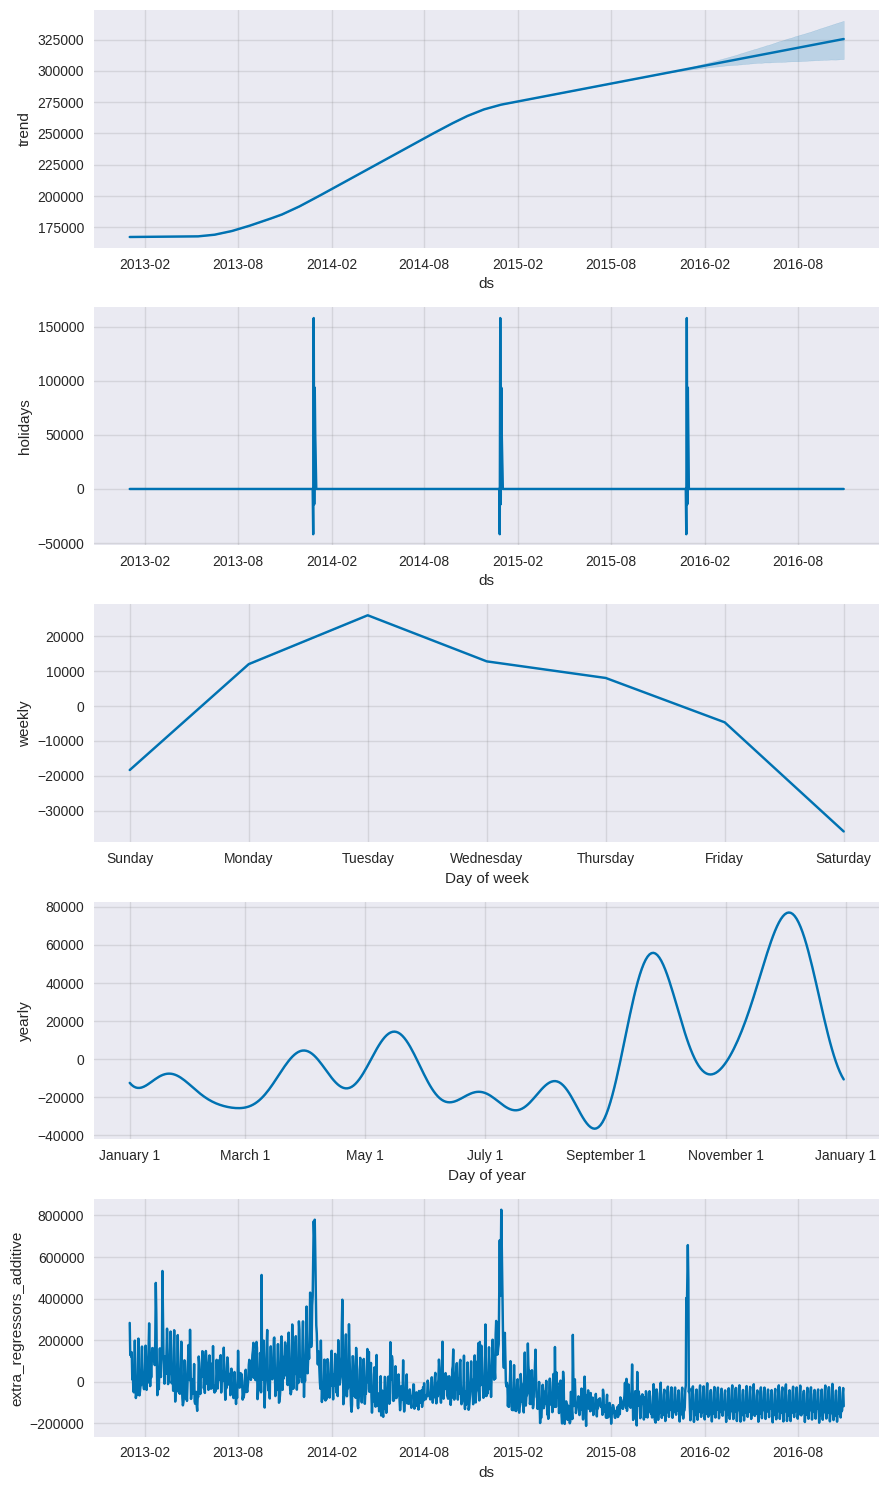

In [ ]:
fig = model_total_revenue.plot_components(forecast_total_revenue)

Forecasting Evaluation

Train-Test Split

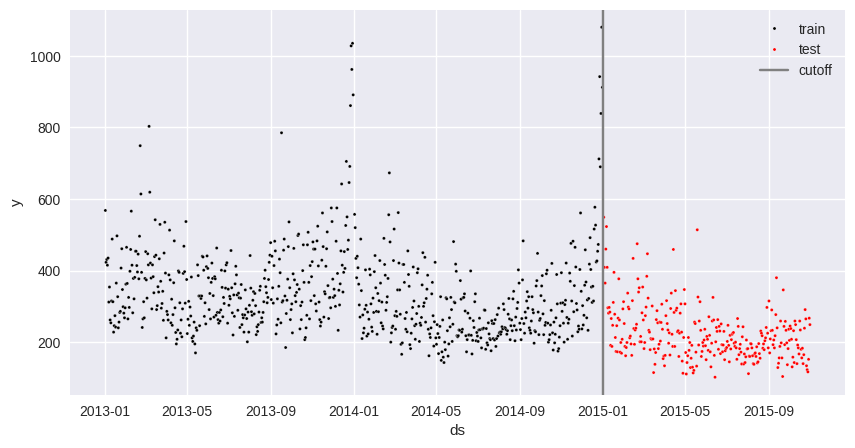

In [ ]:
cutoff = pd.to_datetime('2015-01-01')
daily_total_qty['type'] = daily_total_qty['ds'].apply(
    lambda date: 'train' if date < cutoff else 'test')

plt.figure(figsize=(10, 5))
sns.scatterplot(x='ds', y='y', hue='type', s=5,
                palette=['black', 'red'],
                data=daily_total_qty)
plt.axvline(x=cutoff, color='gray', label='cutoff')
plt.legend()
plt.show()

In [ ]:
train = daily_total_qty[daily_total_qty['ds'] < cutoff]
test = daily_total_qty[daily_total_qty['ds'] >= cutoff]

print(f'Train length: {train.shape[0]} days')
print(f'Test length: {test.shape[0]} days')

Train length: 728 days
Test length: 303 days


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmps54gh3zr/51vrm9r2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmps54gh3zr/8inro_u8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20672', 'data', 'file=/tmp/tmps54gh3zr/51vrm9r2.json', 'init=/tmp/tmps54gh3zr/8inro_u8.json', 'output', 'file=/tmp/tmps54gh3zr/prophet_model9ft1udy2/prophet_model-20240824115850.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:58:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:58:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in

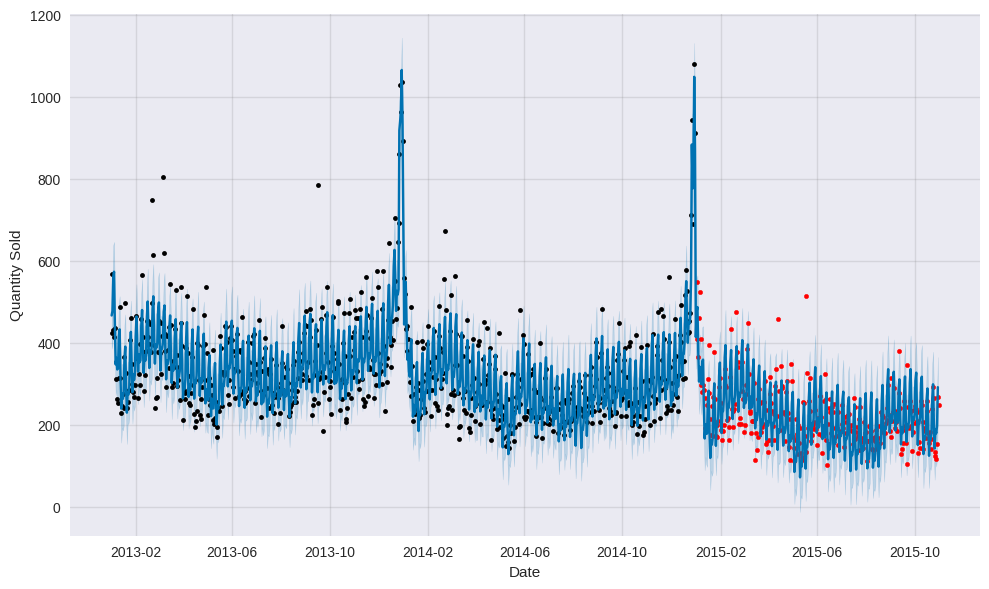

In [ ]:
model_final = Prophet(
    holidays=holiday,  # holiday effect
    yearly_seasonality=True)
# add monthly seasonality
model_final.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model_final.fit(train)  # only training set

# forecasting
future_final = model_final.make_future_dataframe(
    periods=303, freq='D')  # 303 days (test size)
forecast_final = model_final.predict(future_final)

# visualize
fig = model_final.plot(forecast_final, xlabel='Date', ylabel='Quantity Sold')
plt.scatter(x=test['ds'], y=test['y'], s=10, color='red')
plt.show()

Evaluation Metrics

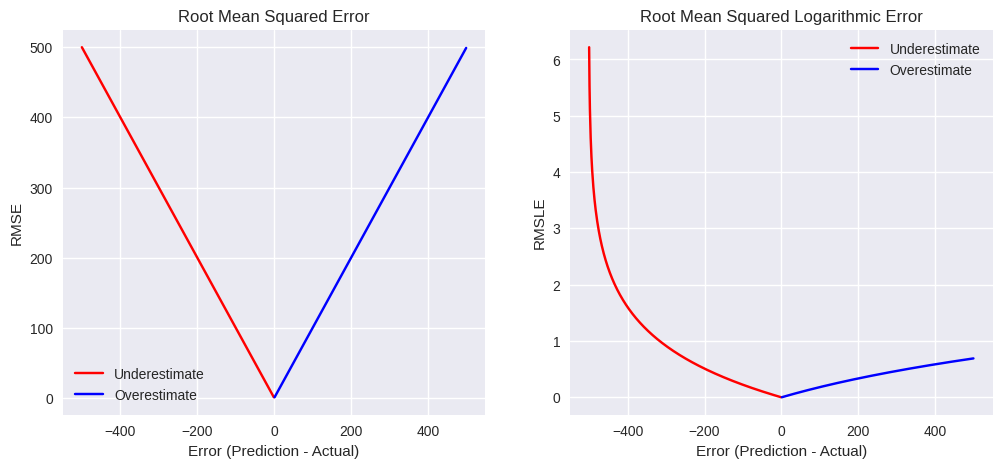

In [ ]:

# calculation
err = np.arange(-500, 500)
p = np.arange(0, 1000)
a = p - err
rmse_plot = np.power(err, 2) ** 0.5
rmsle_plot = np.power(np.log1p(p) - np.log1p(a), 2) ** 0.5

# visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for idx, (ax, y) in enumerate(zip(axes, [rmse_plot, rmsle_plot])):
    ax.plot(err[err < 0], y[err < 0], color='red', label="Underestimate")
    ax.plot(err[err > 0], y[err > 0], color='blue', label="Overestimate")
    ax.set_xlabel("Error (Prediction - Actual)")
    ax.set_ylabel(f"RMS{'L' if idx else ''}E")
    ax.set_title(f"Root Mean Squared {'Logarithmic ' if idx else ''}Error")
    ax.legend()

plt.show()

In [ ]:
forecast_train = forecast_final[forecast_final['ds'] < cutoff]
train_rmsle = mean_squared_log_error(y_true=train['y'],
                                     y_pred=forecast_train['yhat']) ** 0.5
train_rmsle

0.18123775748297982

In [ ]:
forecast_test = forecast_final[forecast_final['ds'] >= cutoff]
test_rmsle = mean_squared_log_error(y_true=test['y'],
                                    y_pred=forecast_test['yhat']) ** 0.5
test_rmsle

0.36569408136155596

Expanding Window Cross Validation

In [ ]:
df_cv = cross_validation(model_total_revenue, initial='730 days', horizon='30 days', period='90 days')
df_cv


INFO:prophet:Making 4 forecasts with cutoffs between 2015-01-04 00:00:00 and 2015-10-01 00:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmps54gh3zr/tp0c4s5x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmps54gh3zr/n90d6od2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72459', 'data', 'file=/tmp/tmps54gh3zr/tp0c4s5x.json', 'init=/tmp/tmps54gh3zr/n90d6od2.json', 'output', 'file=/tmp/tmps54gh3zr/prophet_modelo8rk_uka/prophet_model-20240824120012.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:00:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:00:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmps54gh3zr/t9kxy9ge.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmps54gh3zr/l5d6pwky.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

ds           yhat     yhat_lower     yhat_upper         y  \
0   2015-01-05  452534.546183  337544.377627  564830.251312  357996.0   
1   2015-01-06  528109.330857  420071.354018  636168.254845  562368.0   
2   2015-01-07  399541.896964  282585.348983  515636.072833  290563.0   
3   2015-01-08  281896.193856  163617.578767  393068.548896  285423.0   
4   2015-01-09  255263.792402  147082.522995  358706.420556  232971.0   
..         ...            ...            ...            ...       ...   
115 2015-10-27  111315.369737    4737.630118  218916.377966  111851.0   
116 2015-10-28   91639.852093  -12121.293187  208792.113487  180557.0   
117 2015-10-29  126604.242215   26661.217906  231840.834449  103456.0   
118 2015-10-30  237126.932130  137553.431456  335233.038953  204317.0   
119 2015-10-31  187347.144774   85941.231972  279634.731830  237587.0   

        cutoff  
0   2015-01-04  
1   2015-01-04  
2   2015-01-04  
3   2015-01-04  
4   2015-01-04  
..         ...  
115 2015-10-01  
116 2015-10-01  
117 2015-10-01  
118 2015-10-01  
119 2015-10-01  

[120 rows x 6 columns]

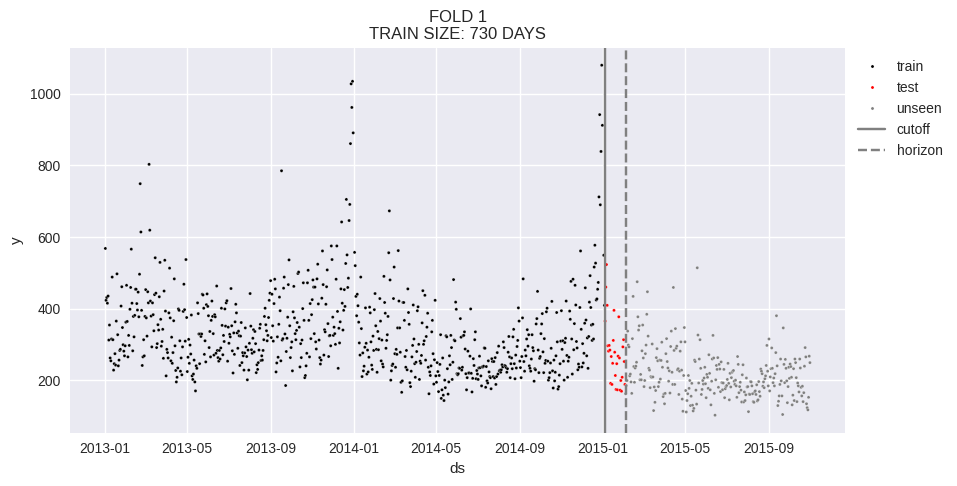

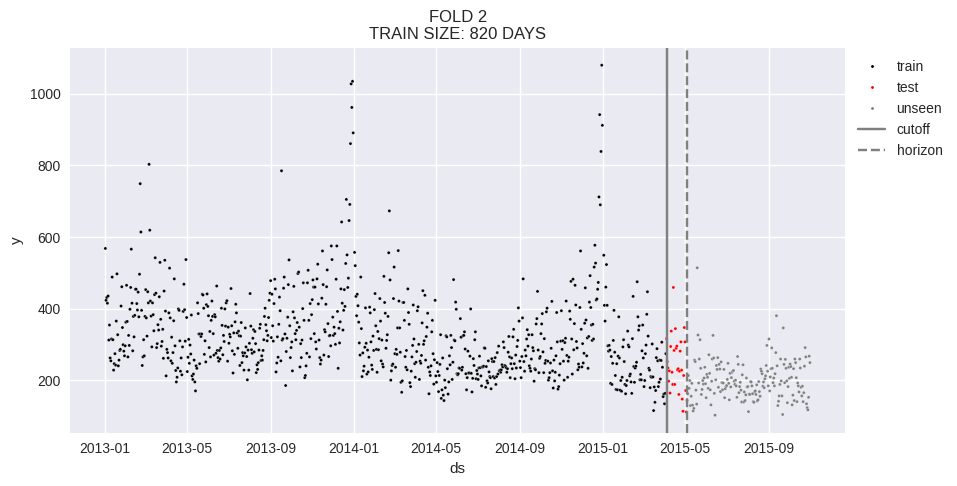

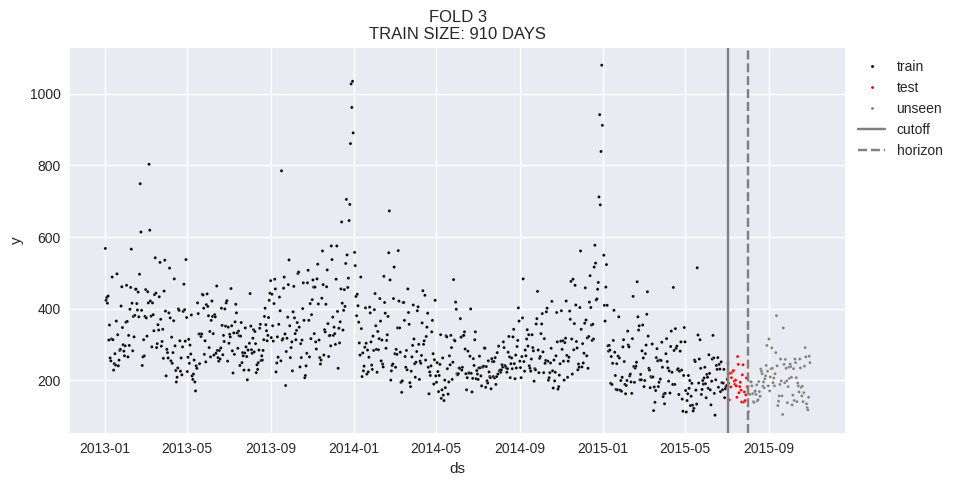

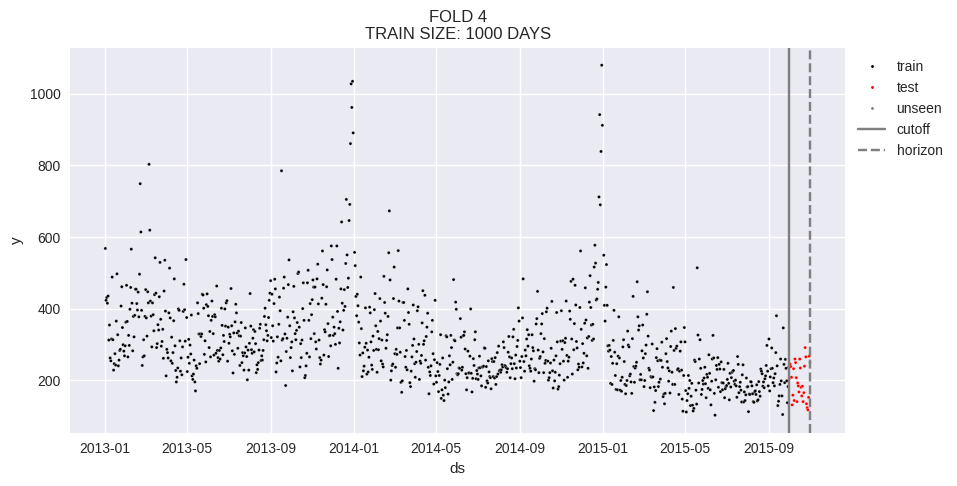

In [ ]:
# for illustration purposes only
df_copy = daily_total_qty[['ds', 'y']].copy()
df_cutoff_horizon = df_cv.groupby('cutoff')[['ds']].max()

for i, (cutoff, horizon) in enumerate(df_cutoff_horizon.iterrows()):
    horizon_cutoff = horizon['ds']

    df_copy['type'] = df_copy['ds'].apply(
        lambda date: 'train' if date < cutoff else
                     'test' if date < horizon_cutoff else 'unseen')

    plt.figure(figsize=(10, 5))
    sns.scatterplot(x='ds', y='y', hue='type', s=5,
                    palette=['black', 'red', 'gray'],
                    data=df_copy)
    plt.axvline(x=cutoff, color='gray', label='cutoff')
    plt.axvline(x=horizon_cutoff, color='gray', ls='--', label='horizon')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.title(
        f"FOLD {i+1}\nTRAIN SIZE: {df_copy['type'].value_counts()['train']} DAYS")
    plt.show()

In [ ]:
cv_rmsle = df_cv.groupby('cutoff').apply(
    lambda x: mean_squared_log_error(y_true=x['y'],
                                     y_pred=x['yhat']) ** 0.5)
cv_rmsle

cutoff
2015-01-04    0.235820
2015-04-04    0.304705
2015-07-03    0.236844
2015-10-01    0.309107
dtype: float64

In [ ]:
cv_rmsle.mean()

0.2716189709386818

In [ ]:
df_p = performance_metrics(df_cv, rolling_window=0)
df_p.tail()

horizon           mse          rmse           mae      mape     mdape  \
25 26 days  3.808108e+09  61709.870007  50329.432677  0.272369  0.274697   
26 27 days  2.683037e+09  51798.038780  40915.176766  0.200158  0.129341   
27 28 days  6.670980e+08  25828.241229  25751.649340  0.208060  0.216793   
28 29 days  1.643801e+09  40543.818182  37560.422589  0.274325  0.249259   
29 30 days  2.442175e+09  49418.365206  46530.651655  0.403657  0.341561   

       smape  coverage  
25  0.230665       1.0  
26  0.235814       1.0  
27  0.188098       1.0  
28  0.267043       1.0  
29  0.350215       1.0

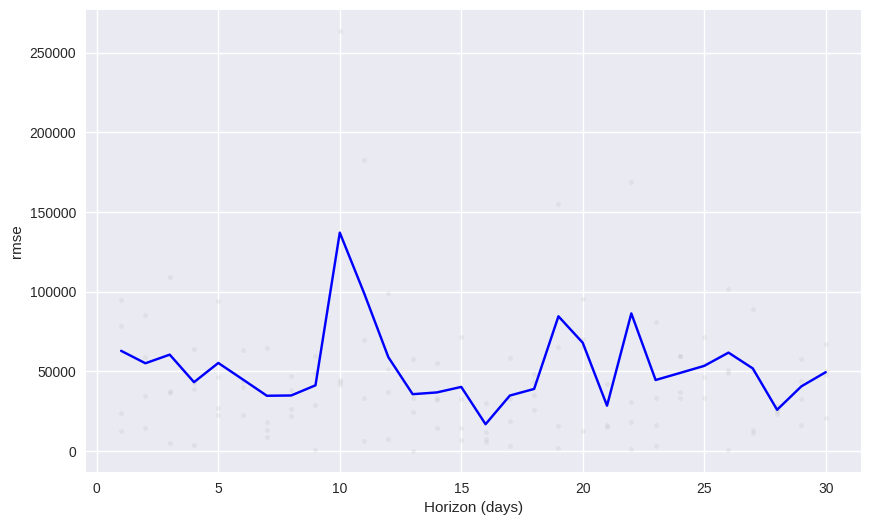

In [ ]:
fig = plot_cross_validation_metric(df_cv, metric='rmse', rolling_window=0)

ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

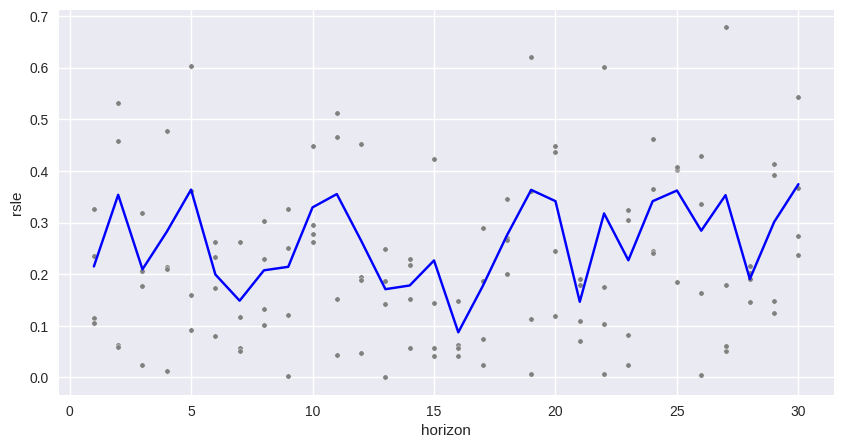

In [ ]:
df_cv['horizon'] = (df_cv['ds'] - df_cv['cutoff']).dt.days
df_cv['sle'] = np.power((np.log1p(df_cv['yhat']) - np.log1p(df_cv['y'])), 2) # squared logarithmic error
df_cv['rsle'] = df_cv['sle'] ** 0.5
horizon_rmsle = df_cv.groupby('horizon')['sle'].apply(lambda x: x.mean() ** 0.5) # root mean

# visualization
plt.figure(figsize=(10, 5))
sns.scatterplot(x='horizon', y='rsle',
                s=15, color='gray',
                data=df_cv)
plt.plot(horizon_rmsle.index, horizon_rmsle, color='blue')
plt.grid(b=True, which='major', color='gray', linestyle='-')
plt.xlabel('Horizon (days)')
plt.ylabel('RMSLE')
plt.show()

Hyperparameter Tuning

In [ ]:
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1],
    'changepoint_range': [0.8, 0.95]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v))
              for v in itertools.product(*param_grid.values())]
rmsles = []  # Store the RMSLEs for each params here

# Use cross validation to evaluate all parameters
for params in tqdm(all_params):
    # fitting model
    # (TO DO: change the data and add other components: seasonality, holiday, regressor)
    model = Prophet(**params,
                    holidays=holiday)
    model.fit(daily_total_qty)

    # Expanding window cross validation (TO DO: use different values)
    cv = cross_validation(model, initial='730 days', period='90 days', horizon='60 days',
                          parallel='processes')

    # Evaluation metrics: RMSLE
    rmsle = cv.groupby('cutoff').apply(
        lambda x: mean_squared_log_error(y_true=x['y'],
                                         y_pred=x['yhat']) ** 0.5)

    mean_rmsle = rmsle.mean()
    rmsles.append(mean_rmsle)

  0%|          | 0/6 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmps54gh3zr/dvcrmg87.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmps54gh3zr/mykqq_g2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58150', 'data', 'file=/tmp/tmps54gh3zr/dvcrmg87.json', 'init=/tmp/tmps54gh3zr/mykqq_g2.json', 'output', 'file=/tmp/tmps54gh3zr/prophet_modelqzxsm799/prophet_model-20240824120256.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:02:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:02:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2015-03-05 00:00:00 and 2015-09-01 00:00:00
INFO:pro

In [ ]:
tuning_results = pd.DataFrame(all_params)
tuning_results['rmsle'] = rmsles
tuning_results.sort_values(by='rmsle')

changepoint_prior_scale  changepoint_range     rmsle
3                    0.010               0.95  0.264303
5                    0.100               0.95  0.264571
4                    0.100               0.80  0.264979
2                    0.010               0.80  0.265464
0                    0.001               0.80  0.267712
1                    0.001               0.95  0.275575

In [ ]:
best_params = all_params[np.argmin(rmsles)]
best_params

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.95}

In [ ]:
model_best = Prophet(**best_params, holidays=holiday)
model_best.fit(daily_total_qty)
model_best

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmps54gh3zr/rxrrtcyv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmps54gh3zr/vdb6psnk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2598', 'data', 'file=/tmp/tmps54gh3zr/rxrrtcyv.json', 'init=/tmp/tmps54gh3zr/vdb6psnk.json', 'output', 'file=/tmp/tmps54gh3zr/prophet_modelzaljjpa2/prophet_model-20240824120334.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:03:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:03:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Final Forecasting Result

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



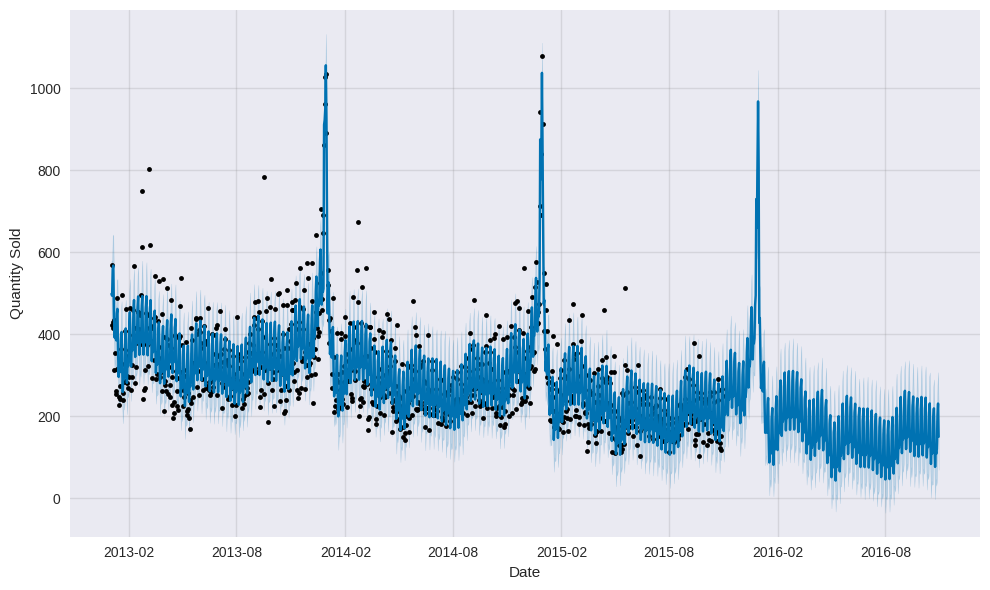

In [ ]:
future_best = model_best.make_future_dataframe(periods=365, freq='D')
forecast_best = model_best.predict(future_best)

# visualize
fig = model_best.plot(forecast_best, xlabel='Date', ylabel='Quantity Sold')